### This notebook demonstrates the alternative DCTR fitting method applied on Lund jet datasets

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [3]:
# standard library imports
from __future__ import absolute_import, division, print_function

import keras

# standard numerical library imports
import numpy as np
import scipy as sp

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, remap_pids, to_categorical

import matplotlib.pyplot as plt

import keras.backend as K
import cntk as C

Using TensorFlow backend.
/root/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/root/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/root/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/root/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/dtype

In [31]:
import tensorflow as tf

In [4]:
from IPython.display import Image, display

## Utilities

In [5]:
# normalize pT and center (y, phi)
def normalize(x):
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

In [6]:
def preprocess_data(X):
    for x in X:
        normalize(x)
    
    # Remap PIDs to unique values in range [0,1]
    remap_pids(X, pid_i=3)
    return X

In [21]:
# network architecture parameters
Phi_sizes = (100,100, 128)
F_sizes = (100,100, 100)

dctr = PFN(input_dim=7, 
           Phi_sizes=Phi_sizes, F_sizes=F_sizes,
           summary=True)

#load model from saved file
dctr.model.load_weights('./saved_models/DCTR_ee_dijets_1D_aLund.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 7)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    800         input[0][0]                      
__________________________________________________________________________________________________
activation_8 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_8[0][0]               
__________________________________________________________________________________________________
activation

In [8]:
test_dataset_0 = np.load('test1D_default.npz')
test_dataset_1 = np.load('test1D_aLund.npz')

In [20]:
dctr

## Load Data

In [9]:
X_default = preprocess_data(test_dataset_0['jet'][:,:,:4])
X_unknown = preprocess_data(test_dataset_1['jet'][:,:,:4])

Y_default = np.zeros_like(X_unknown[:,0,0])
Y_unknown = np.ones_like(X_unknown[:,0,0])

In [10]:
X_fit = np.concatenate((X_default, X_unknown), axis = 0)

Y_fit = np.concatenate((Y_default, Y_unknown), axis = 0)
Y_fit = to_categorical(Y_fit, num_classes=2)

In [11]:
X_fit, _, Y_fit, _ = data_split(X_fit, Y_fit, test=0, shuffle=True)

# Fitting

## Loss Curve Model

In [12]:
class AddParams2Input(keras.layers.Layer):
    """ Custom layer for tuning with DCTR: 
    Arguments:
    - n_MC_params : (int) - the number of n_MC_params that are in X_dim
    - default_MC_params : (list of floats) - default values for each of the MC parameters
    - trainable_MC_params : (list of booleans) - True for parameters that you want to fit, false for parameters that should be fixed at default value

    Usage: 
    Let X_dim be the input dimension of each particle to a PFN model, and n_MC_params be the number of MC parameters. 
    Defines a Layer that takes in an array of dimension 
    (batch_size, padded_multiplicity, X_dim - n_MC_params)
    This layer appends each particle by the default_MC_params and makes then trainable or non-trainable based on trainable_MC_params
    """
    
    def __init__(self, n_MC_params, default_MC_params, trainable_MC_params):
        super(AddParams2Input, self).__init__()
        # Definitions
        self.n_MC_params = n_MC_params
        self.MC_params = default_MC_params
        self.trainable_MC_params = trainable_MC_params

    
    def build(self, input_shape):
        # Convert input MC parameters to weights and make then trainable or non-trainable
        for i in range(self.n_MC_params):
            self.MC_params[i] = self.add_weight(name='MC_param_{}'.format(i), 
                                                shape=(1, 1),
                                                initializer=keras.initializers.Constant(self.MC_params[i]),
                                                trainable=self.trainable_MC_params[i])
            
        self.MC_params = keras.backend.tf.concat(self.MC_params, axis = -1)
        super(AddParams2Input, self).build(input_shape)
    
    def call(self, input):
        # Add MC params to each input particle (but not to the padded rows)
        concat_input_and_params = keras.backend.tf.where(keras.backend.abs(input[...,0])>0,
                                                         self.MC_params*keras.backend.ones_like(input[...,0:self.n_MC_params]),
                                                         keras.backend.zeros_like(input[...,0:self.n_MC_params]))
        return keras.backend.concatenate([input, concat_input_and_params], -1)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1]+self.n_MC_params)

In [13]:
from tensorflow.python.framework import ops
from tensorflow.python.ops import nn
from tensorflow.python.ops import variables as variables_module

def _backtrack_identity(tensor):
    while tensor.op.type == 'Identity':
        tensor = tensor.op.inputs[0]
    return tensor

def my_loss_wrapper():
    def my_loss(y_true,y_pred):
        target = y_true
        output = y_pred
        axis = -1
        from_logits = False
        target.shape.assert_is_compatible_with(output.shape)
        if from_logits:
            return nn.softmax_cross_entropy_with_logits_v2(
                labels=target, logits=output, axis=axis)

        if not isinstance(output, (ops.EagerTensor, variables_module.Variable)):
            output = _backtrack_identity(output)
            if output.op.type == 'Softmax':
                # When softmax activation function is used for output operation, we
                # use logits from the softmax function directly to compute loss in order
                # to prevent collapsing zero when training.
                # See b/117284466
                assert len(output.op.inputs) == 1
                output = output.op.inputs[0]
                return nn.softmax_cross_entropy_with_logits_v2(
                  labels=target, logits=output)

        # scale preds so that the class probas of each sample sum to 1
        output = output / math_ops.reduce_sum(output, axis, True)
        # Compute cross entropy from probabilities.
        epsilon_ = _constant_to_tensor(epsilon(), output.dtype.base_dtype)
        output = clip_ops.clip_by_value(output, epsilon_, 1. - epsilon_)
        return -math_ops.reduce_sum(target * math_ops.log(output), axis)
    return my_loss

In [14]:
def get_DCTR_fit_model(DCTR_model, 
                       X_dim, 
                       n_MC_params, 
                       default_MC_params,
                       trainable_MC_params):
    """ 
    Get a DCTR model that trains on the input MC parameters
    
    Arguments:
    - DCTR_model : a PFN model that has been trained on a to continuously interpolate over the input MC dimensions
    - X_dim : (int) - the dimension of the input expected by DCTR_model
    - n_MC_params : (int) - the number of n_MC_params that are in X_dim
    - default_MC_params : (list of floats) - default values for each of the MC parameters
    - trainable_MC_params : (list of booleans) - True for parameters that you want to fit, false for parameters that should be fixed at default value

    Returns:
    - DCTR_fit_model: a compiled model that gradient descends only on the trainable MC parameters
    """
    
    # Do sanity checks on inputs
    assert X_dim >=n_MC_params, "X_dim must be larger than n_MC_params. X_dim includes the dimensionality of the 4-vector + number of MC parameters"
    assert n_MC_params == len(default_MC_params), "Dimension mismatch between n_MC_params and number of default MC parameters given. len(default_MC_params) must equal n_MC_params"
    assert n_MC_params == len(trainable_MC_params), "Dimension mismatch between n_MC_params and trainable_MC_params. len(trainable_MC_params) must equal n_MC_params."
    assert np.any(trainable_MC_params), "All parameters are set to non-trainable."
    
    # Define input to DCTR_fit_model
    non_param_input = keras.layers.Input((None, X_dim - n_MC_params))

    # Construct layer that adds trainable and non-trainable parameters to the input
    add_params_layer = AddParams2Input(n_MC_params, default_MC_params, trainable_MC_params)
    time_dist     = keras.layers.TimeDistributed(add_params_layer, name='tdist')(non_param_input)     

    # Set all weights in DCTR_model to non-trainable
    for layer in DCTR_model.model.layers:
        layer.trainable = False
        
    # get the graph and the weights from the DCTR_model
    output = DCTR_model.model(inputs = time_dist)

    # Define full model
    DCTR_fit_model = fitmodel = keras.models.Model(inputs = non_param_input, outputs = output)
    optimizer = keras.optimizers.Adam(lr=1e-4)
    # Compile with loss function
    DCTR_fit_model.compile(optimizer=optimizer, loss=my_loss_wrapper())
    
    
    return DCTR_fit_model

In [15]:
def set_MC_params(dctr_fit_model, MC_params):
    alphaS, aLund, StoUD = MC_params
    weights = [np.array([[alphaS]],   dtype=np.float32),
               np.array([[aLund]],    dtype=np.float32),
               np.array([[StoUD]], dtype=np.float32)]
    dctr_fit_model.layers[1].set_weights(weights)

In [16]:
def get_loss(X, Y, dctr_fit_model, MC_params, batch_size = 1000):
    set_MC_params(dctr_fit_model, MC_params)
    return dctr_fit_model.evaluate(x=X, y = Y, batch_size=batch_size)

In [17]:
dctr_fit_model = get_DCTR_fit_model(dctr, 
                       X_dim =7, 
                       n_MC_params = 3, 
                       default_MC_params   = [0.1365, 0.68, 0.217], # default params for [alpha_s, aLund, StoUD]
                       trainable_MC_params = [False, True, False]) # Only train aLund

### Compute weight to use in loss function

In [34]:
thetas = np.linspace(0.6,0.9, 20)
train_result_list = []
for i in range(len(thetas)):
    weight_value = dctr.predict(test_dataset_0['jet'][:100000,:,:])
    weight = weight_value[:,0]/weight_value[:,1]
    weight = tf.convert_to_tensor(weight.astype(np.float32))
    train_result_list.append(weight)

### Define neural network g

In [38]:
from keras.layers import Lambda, Dense, Input, Layer, Dropout
from keras.models import Model

In [39]:
myinputs = Input(shape=(1,))

x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)
          
model = Model(inputs=myinputs, outputs=predictions)

def my_loss_wrapper(weight,val=0.0):
            
    theta0 = val #target value 
    def my_loss(y_true,y_pred):
        t_loss = y_true*(y_true - y_pred)**2+(weight**2)*(1.-y_true)*(y_true - y_pred)**2
        return K.mean(t_loss)
    return my_loss

In [40]:
lvals = []
for i in range(len(thetas)):
    theta = thetas[i]
    model.compile(optimizer='adam', loss=my_loss_wrapper(train_result_list[i],theta),metrics=['accuracy'])
    model.fit(X_fit[:int(len(X_fit)/10)], Y_fit[:int(len(X_fit)/10)], epochs=1, batch_size=int(len(X_fit)/10),validation_data=(X_fit[-int(len(X_fit)/10):], Y_fit[-int(len(X_fit)/10):]),verbose=1)
    lvals+=[model.history.history['val_loss']]
    print
    pass
print(lvals) 

ValueError: Error when checking input: expected input_3 to have 2 dimensions, but got array with shape (180000, 51, 4)

In [90]:
aLund_loss = np.array([(aLund, get_loss(X_fit[:int(len(X_fit)/10)], Y_fit[:int(len(X_fit)/10)], dctr_fit_model, [aLund, 0.1365, 0.217])) for aLund in thetas])

180000/180000 [==============================] - 64s 354us/step


In [91]:
aLund_loss

array([[0.6       , 0.69359449],
       [0.61578947, 0.69350439],
       [0.63157895, 0.69341753],
       [0.64736842, 0.69333671],
       [0.66315789, 0.69325262],
       [0.67894737, 0.69316377],
       [0.69473684, 0.693074  ],
       [0.71052632, 0.69299457],
       [0.72631579, 0.69293157],
       [0.74210526, 0.69288282],
       [0.75789474, 0.69285285],
       [0.77368421, 0.69283769],
       [0.78947368, 0.69283435],
       [0.80526316, 0.69283885],
       [0.82105263, 0.69284742],
       [0.83684211, 0.6928584 ],
       [0.85263158, 0.69286957],
       [0.86842105, 0.69288147],
       [0.88421053, 0.69289347],
       [0.9       , 0.69290492]])

In [92]:
aLund_loss[:,0], aLund_loss[:,1]

(array([0.6       , 0.61578947, 0.63157895, 0.64736842, 0.66315789,
        0.67894737, 0.69473684, 0.71052632, 0.72631579, 0.74210526,
        0.75789474, 0.77368421, 0.78947368, 0.80526316, 0.82105263,
        0.83684211, 0.85263158, 0.86842105, 0.88421053, 0.9       ]),
 array([0.69359449, 0.69350439, 0.69341753, 0.69333671, 0.69325262,
        0.69316377, 0.693074  , 0.69299457, 0.69293157, 0.69288282,
        0.69285285, 0.69283769, 0.69283435, 0.69283885, 0.69284742,
        0.6928584 , 0.69286957, 0.69288147, 0.69289347, 0.69290492]))

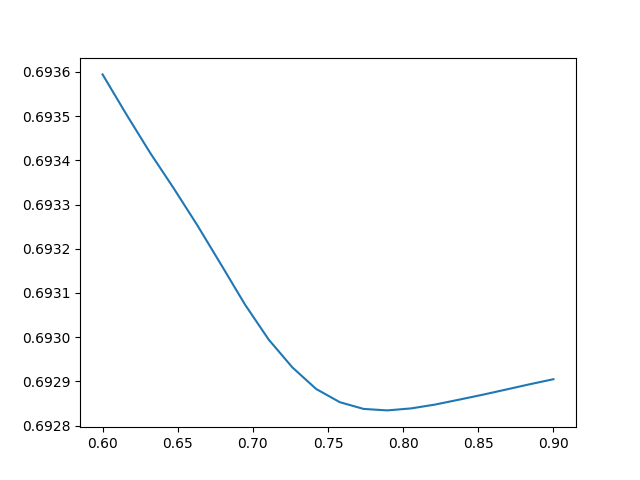

In [93]:
import matplotlib.pyplot as plt
plt.cla()
plt.plot(aLund_loss[:,0],aLund_loss[:,1])
plt.savefig("aLund.png")
display(Image(filename="aLund.png"))

In [ ]:
A = [1,2,3,4,5]